# Automatic Valuation Model

**Dataset Description**



In [ ]:
import pandas as pd
import numpy as np
import os

import regex as re

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data = pd.read_csv('dataset_jul20.csv')
data_dict = pd.read_csv('dictionary.csv')
data.shape

(2500, 20)

In [ ]:
data.head(20)

,id,thoroughfare_id,census2016_settlement_geogid,census2016_small_area_geogid,local_authority_id,post_county_name,eircode_area_code,postal_address,new_home_ind,sold_date,sold_price,lat,lon,building_property_subtype_code,building_shape_area_value,sqm_value,yoc_value,storey_value,beds_value,baths_value
0,432259,1200015895,35001.00,A268003007,29,dublin,D07,apartment 183 the spinnaker arran quay dublin ...,0,8/24/2015,165000,53.35,-6.28,multi-family,nan,nan,1993.00,1.00,1.00,nan
1,679044,1200045364,4009.00,A267111010,27,dublin,D13,3 the green station manor dublin 13 d13 v1dv,1,11/20/2018,547577,53.42,-6.15,mid-terrace,66.59,nan,2017.00,nan,nan,nan
2,1322973,1200010380,35001.00,A267024001,28,dublin,A94,1 rockford terrace deansgrange road deansgrang...,0,6/21/2016,443750,53.29,-6.17,mid-terrace,69.19,nan,nan,nan,nan,nan
3,28508,1200000258,35001.00,A267017013,28,dublin,A94,59 the beeches monkstown valley monkstown blac...,0,7/20/2018,417000,53.29,-6.16,semidetached,nan,nan,nan,nan,nan,nan
4,148784,1200007329,35001.00,A268149001,29,dublin,D08,flat 1 41 victoria quay dublin 8 d08 nf2w,0,6/20/2018,250000,53.35,-6.28,multi-family,nan,nan,nan,1.00,nan,nan
5,735717,1200010633,35001.00,A267095026,27,dublin,D13,4 thormanby woods howth co. dublin d13 t261,0,10/22/2013,665000,53.38,-6.06,bungalow,193.73,208.60,1989.00,2.00,4.00,2.00
6,508706,1200013383,35001.00,A268005003,29,dublin,D07,16a arbour hill dublin 7 d07 p798,0,11/9/2018,370000,53.35,-6.28,end-terrace,43.83,69.84,1990.00,2.00,3.00,1.00
7,1610739,1200003654,35001.00,A268138012,29,dublin,D01,apartment 41 block b the courtyard hill street...,0,6/9/2016,250000,53.35,-6.26,multi-family,nan,nan,2005.00,1.00,nan,nan
8,61576,1200038124,35001.00,A268098006,29,dublin,D08,apartment 20 friary close cook street dublin 8...,0,5/15/2018,325000,53.34,-6.27,multi-family,nan,72.60,1990.00,2.00,3.00,nan
9,99670,1200013386,35001.00,A268082004,29,dublin,D07,apartment 16 the old distillery anne street no...,0,3/13/2019,290000,53.35,-6.27,multi-family,nan,nan,2000.00,1.00,nan,nan


In [ ]:
data_dict

,id,unique identifier
0,thoroughfare_id,thoroughfare unique identifier
1,census2016_settlement_geogid,census settlement unique identifier - https://...
2,census2016_small_area_geogid,census small area unique identifier - https://...
3,local_authority_id,local authorithy unique identifier
4,post_county_name,county name
5,eircode_area_code,eircode area
6,postal_address,address of the subject property
7,new_home_ind,new home indicator. 1 means Yes. 0 means No
8,sold_date,sold date
9,sold_price,sold price


## Feature Engineering

Id columns are not relevant to our use case. So let's drop it

In [ ]:
data.drop(columns = ['id','thoroughfare_id','census2016_settlement_geogid','census2016_small_area_geogid', 'local_authority_id'],inplace=True)

Let's check the NA/Missing values in the dataset

In [ ]:
new_data = data.copy()
new_data.isna().sum()

post_county_name                     0
eircode_area_code                    0
postal_address                       0
new_home_ind                         0
sold_date                            0
sold_price                           0
lat                                  0
lon                                  0
building_property_subtype_code       0
building_shape_area_value         1446
sqm_value                          887
yoc_value                          528
storey_value                       287
beds_value                        1181
baths_value                       1987
dtype: int64

Visualising percentage of missing values per column in the chart below

Text(0.5, 1.0, 'Percentage of missing values per feature')

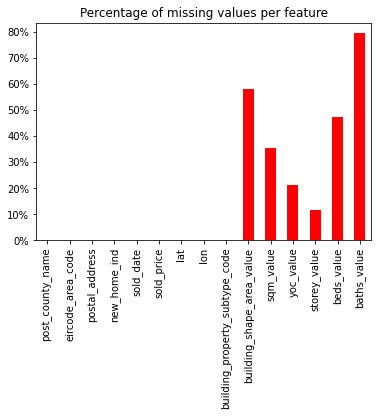

In [ ]:
ax = (new_data.isnull().mean() * 100).plot(kind='bar', color ='red')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of missing values per feature')

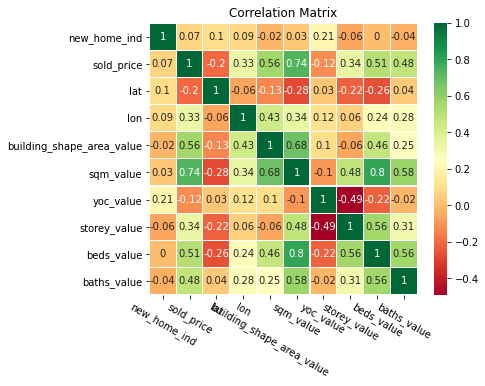

In [ ]:
cor_plot = sns.heatmap(new_data.corr().round(2),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

Segregate nominal and quantitative features.

Numerical_variables :

['id', 'thoroughfare_id', 'census2016_settlement_geogid', 'local_authority_id', 'new_home_ind', 'sold_price', 'lat', 'lon', 'building_shape_area_value', 'sqm_value', 'yoc_value', 'storey_value', 'beds_value', 'baths_value']

Categorical_variables :

['census2016_small_area_geogid', 'post_county_name', 'eircode_area_code', 'postal_address', 'sold_date', 'building_property_subtype_code']

In [ ]:
duplicate = new_data[new_data.duplicated()]
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,post_county_name,eircode_area_code,postal_address,new_home_ind,sold_date,sold_price,lat,lon,building_property_subtype_code,building_shape_area_value,sqm_value,yoc_value,storey_value,beds_value,baths_value


**Target column is positively skewed, it will affect our regression predictions hence we need to normalise target column**

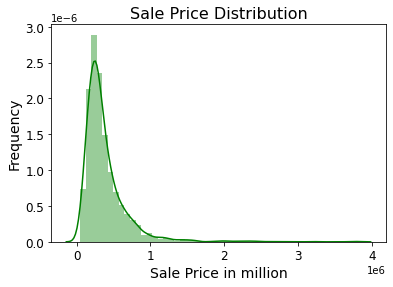

In [ ]:
sns.distplot(new_data['sold_price'], color = 'g')
plt.title('Sale Price Distribution', fontsize = 16)
plt.xlabel('Sale Price in million', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#plt.savefig('distplot.png')
plt.show()

***Missing value imputation***

***Sold price is highly correlated with sqm value, beds value, baths value, building shape area value. But at the same time, these are the features having highest missing values. We can use highly correlated features to impute missing values.***

###### **Feature Baths value**

 Baths Value has around 80% missing values. We can do two things here
 1. Since baths_value is highly correlated with beds value we can find the average baths per bedroom and try to impute the value. 
 2. We can drop the feature later if it isn't important as around 80% of the data is missing. 
 
 Let's impute it for now after some analysis of the feature

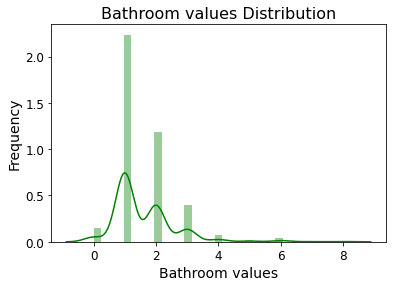

In [ ]:
sns.distplot(new_data['baths_value'], color = 'g')
plt.title('Bathroom values Distribution', fontsize = 16)
plt.xlabel('Bathroom values', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#plt.savefig('distplot.png')
plt.show()

A house cannot be built without a bath, so 0 bath is not possible. Let's replace it with the median value and calculate the ratio of beds to baths as the variable is skewed, the mean is biased by the values at the far end of the distribution. Therefore, the median is a better representation of the majority of the values in the variable.

It has been visualised with a histogram of the distribution

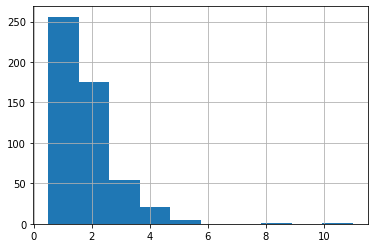

In [ ]:
new_data['baths_value']=new_data['baths_value'].replace(0,new_data['baths_value'].median())
new_data['beds per bath'] = (new_data['beds_value']/new_data['baths_value'])
new_data['beds per bath'].hist()

From the above plot we can infer that mostly there is 1 or 2 baths per bed

In [ ]:
new_data.isna().sum()

post_county_name                     0
eircode_area_code                    0
postal_address                       0
new_home_ind                         0
sold_date                            0
sold_price                           0
lat                                  0
lon                                  0
building_property_subtype_code       0
building_shape_area_value         1446
sqm_value                          887
yoc_value                          528
storey_value                       287
beds_value                        1181
baths_value                       1987
beds per bath                     1987
dtype: int64

To fill the remaining baths value we can divide beds value with the mean of the newly created column of beds per bath 

In [ ]:
new_data['approx baths'] = np.round(new_data['beds_value']/new_data['beds per bath'].mean())
new_data['baths_value'].fillna(new_data['approx baths'],inplace = True)

In [ ]:
new_data.drop(columns
              = ['approx baths','beds per bath'], axis=1, inplace=True)

In [ ]:
(new_data.isna().sum()/new_data.shape[0])*100

post_county_name                  0.00
eircode_area_code                 0.00
postal_address                    0.00
new_home_ind                      0.00
sold_date                         0.00
sold_price                        0.00
lat                               0.00
lon                               0.00
building_property_subtype_code    0.00
building_shape_area_value        57.84
sqm_value                        35.48
yoc_value                        21.12
storey_value                     11.48
beds_value                       47.24
baths_value                      47.24
dtype: float64

We have reduced the NA percentage of beds from 80% to 47% letting 50% filling of missing values

###### **Feature Building_shape_area_value**

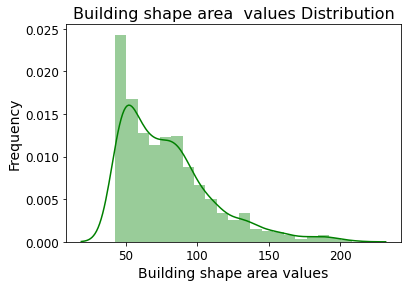

In [ ]:
sns.distplot(new_data['building_shape_area_value'], color = 'g')
plt.title('Building shape area  values Distribution', fontsize = 16)
plt.xlabel('Building shape area values', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#plt.savefig('distplot.png')
plt.show()

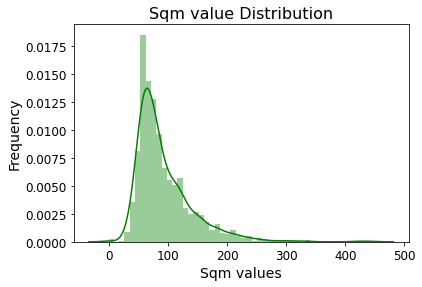

In [ ]:
sns.distplot(new_data['sqm_value'], color = 'g')
plt.title('Sqm value Distribution', fontsize = 16)
plt.xlabel('Sqm values', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#plt.savefig('distplot.png')
plt.show()

**As seen both these column follow a simlar distribution, and have good positive correlation we can use sqm value column to impute missing values of Building shape area value column. Lets check whether we are right or not, by using sqm value as a reference to impute Building shape area value column as it would be visible in correlation matrix**

Following a similar approach as above, we can do the same with the feature building_shape_area_value as its highly correlated with sqm_value

In [ ]:
new_data[new_data['building_shape_area_value'].notnull() & new_data['sqm_value'].notnull()][['building_shape_area_value','sqm_value']]
new_data['area_div'] = new_data['building_shape_area_value']/new_data['sqm_value']
#print(new_data['area_div'])
new_data['approx building area'] = np.round(new_data['sqm_value']*new_data['area_div'].median())
new_data['building_shape_area_value'].fillna(new_data['approx building area'],inplace = True)

**Dropping postal address as it has no meaning to our modelling because we have county and eircode**


In [ ]:
#Dropping columns we created.
new_data.drop(['postal_address','approx building area', 'area_div'],axis=1,inplace=True)

##### **Feature Sold_date and yoc_value**

We can extract the features month and year from Sold_date and drop the column altogether. Day level data is not going to affect our problem as it is too granular, so we do not extract the day from the date column

In [ ]:
new_data['month'] = new_data['sold_date'].apply(lambda x:int(x.split('/')[1]))
new_data['year'] = new_data['sold_date'].apply(lambda x:int(x.split('/')[2]))
new_data.rename(columns = {'month' : 'sold_month','year' : 'sold_year'},inplace = True)
new_data.drop('sold_date',axis=1,inplace=True)

Month can be further grouped into quarters. (Q1,Q2,Q3,Q4)

In [ ]:
new_data.loc[new_data['sold_month'] <= 3, 'Quarter'] = 'Q1'
new_data.loc[(new_data['sold_month'] > 3) & (new_data['sold_month'] <= 6), 'Quarter'] = 'Q2'
new_data.loc[(new_data['sold_month'] > 6) & (new_data['sold_month'] <= 9), 'Quarter'] = 'Q3'
new_data.loc[new_data['sold_month'] >= 10, 'Quarter'] = 'Q4'

Discretize the column sold_year and yoc_value into 4 equal bins each because it is easier to work with year columns when it is in a range

In [ ]:
new_data['sold_year'] = new_data['sold_year'].astype('int')
new_data['soldyear_disc'] = pd.qcut(new_data['sold_year'],4)

**Year of construction, is greater than sold year**

In [ ]:
new_data[new_data['yoc_value'] > new_data['sold_year']].shape

(46, 17)

In [ ]:
set(new_data['soldyear_disc'] )

{Interval(2009.999, 2014.0, closed='right'),
 Interval(2014.0, 2016.0, closed='right'),
 Interval(2016.0, 2018.0, closed='right'),
 Interval(2018.0, 2019.0, closed='right')}

Around 46 data points have year of construction greater than the sold year.  This may be possible in rare cases when the house is being constructed because the contractor must have sold the house on the basis of area map or construction map and people have bought it before it even getting started to construct. The difference between the years shouldn't be much in this case because the house in question should have started construction after being sold.

In [ ]:
nd = new_data[new_data['yoc_value'] > new_data['sold_year']]

(nd['yoc_value']-nd['sold_year']).describe()


count   46.00
mean     3.72
std      1.92
min      1.00
25%      2.00
50%      3.50
75%      5.00
max      7.00
dtype: float64

**These 46 datapoints are clearly indicating a different analysis, which according to me is the contractor must have sold the house on the basis of area map or construction map and people have bought it before it even getting started to construct. The difference between the years shouldn't be much in this case because the house in question should have started construction after being sold.**

Binning year of construction using quantile based discretization into 4 bins to see how the the column is distributed percentile wise.

In [ ]:
new_data['yoc_value'].fillna(new_data['yoc_value'].median(),inplace=True)
new_data['yoc_disc'] = pd.qcut(new_data['yoc_value'],4)

In [ ]:
new_data.drop(columns = ['sold_month','sold_year','yoc_value'],axis=1, inplace=True)

Divided or binned sold_year into intervals of years so as to get insight like particular interval and in that specific quarter is having selling price of real-estate in this range.

In [ ]:
set(new_data['soldyear_disc'])

{Interval(2009.999, 2014.0, closed='right'),
 Interval(2014.0, 2016.0, closed='right'),
 Interval(2016.0, 2018.0, closed='right'),
 Interval(2018.0, 2019.0, closed='right')}

**Check binning if it helps or not**

Text(0.5, 1.0, 'Sold price across years and quarters')

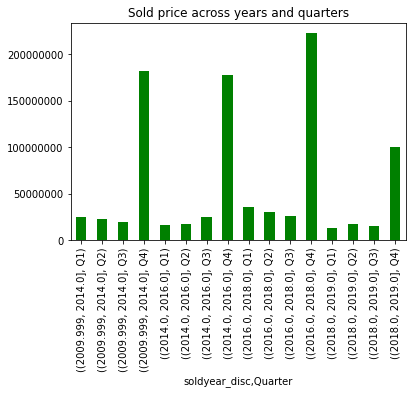

In [ ]:
ax = new_data.groupby(['soldyear_disc','Quarter'])['sold_price'].sum().plot(kind = 'bar', color = 'green')
# ax.ticklabel_format(useOffset=False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Sold price across years and quarters')

##### **Features eircode_area_code and post_county_name**


In [ ]:
eir_grouped_data = new_data[['eircode_area_code','sold_price']].groupby('eircode_area_code').agg(['count','mean']).reset_index().sort_values([('sold_price','mean')], ascending =False)

In [ ]:
eir_grouped_data

eircode_area_code sold_price           
                          count       mean
6                D06         26 1232416.54
11               D18          3 1230189.67
1                A96         81  616466.33
0                A94        254  589791.35
10               D14        134  567203.12
5                D04        518  454276.78
9                D13        175  415446.78
4                D02         51  407089.69
2                A98         44  399659.09
3                D01        152  279501.50
7                D07        782  245761.01
12               D24        200  214000.01
8                D08         80  189679.69

**The below graph indicates the count of properties and their mean prices 
sorted in descending order per EIR code. The axis on the left indicates the count and the one on the right indicates mean of sold_price.**

Text(0.5, 1.0, 'Sold_price across EIR codes')

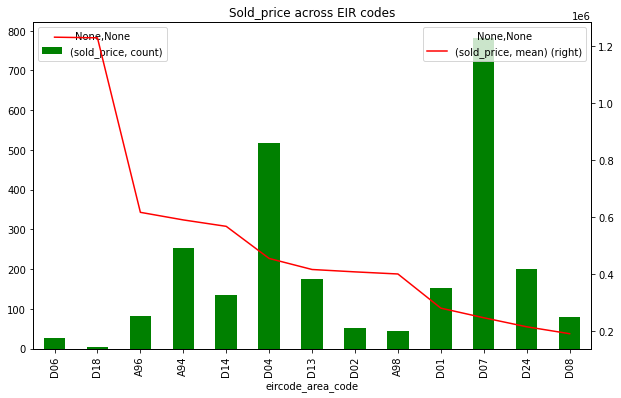

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
eir_grouped_data.plot('eircode_area_code',('sold_price','count'),kind='bar', color = 'green', ax=ax1, legend =True)
eir_grouped_data.plot('eircode_area_code',('sold_price','mean'),kind='line',secondary_y = True, ax=ax2, color = 'r', legend =True)
plt.title('Sold_price across EIR codes')

**We can segregate the EIR code column into 3 logical classes - "EIRCodes with high price", "with medium price" and "with low price"**

In [ ]:
eir_high = ['D06','D18','A96','A94','D14']
eir_med = ['D04','D13','D02','A98','D01']
eir_low = ['D07','D24','D08']
new_data.loc[new_data['eircode_area_code'].isin(eir_high), 'eir_value'] = 'high_eir_counties'
new_data.loc[new_data['eircode_area_code'].isin(eir_med), 'eir_value'] = 'med_eir_counties'
new_data.loc[new_data['eircode_area_code'].isin(eir_low), 'eir_value'] = 'low_eir_counties'

In [ ]:
new_data.drop(columns = ['eircode_area_code'] ,axis=1, inplace=True)

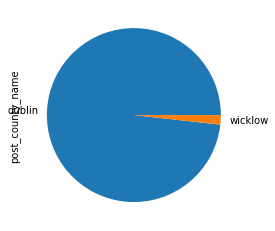

In [ ]:
# Distribution of properties across counties
new_data['post_county_name'].value_counts().plot(kind='pie')

***The distribution of the counties is skewed towards Dublin i.e.98.2%. This might affect our predictions later.Though it is  skewed towards Dublin as we  need more counties for comparative analysis of county-wise distribution of more data about Wicklow.***

**Comparing correlation score after imputation of missing value, its been observed that our hypothesis was correct. Correlation score increased as can be seen in correlation matrix, after imputing missing values with the help of correlated columns.**

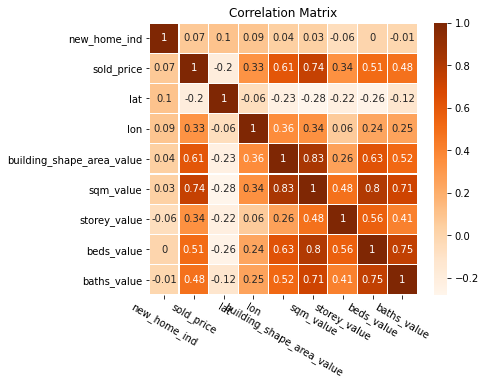

In [ ]:
cor_plot = sns.heatmap(new_data.corr().round(2),annot=True,cmap='Oranges',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

##### **Features Longitude and Latitude**

Since longitude and latitude hardly varies and data constitutes just Ireland counties therefore I would be dropping lat and lon as it does not contribute to my analysis.

In [ ]:

new_data.drop( ['lat','lon'],axis=1,inplace=True)

In [ ]:
new_data.columns

Index(['post_county_name', 'new_home_ind', 'sold_price',
       'building_property_subtype_code', 'building_shape_area_value',
       'sqm_value', 'storey_value', 'beds_value', 'baths_value', 'Quarter',
       'soldyear_disc', 'yoc_disc', 'eir_value'],
      dtype='object')

Splitting categorical and numeric features

In [ ]:
new_data_cat = new_data[['post_county_name','eir_value','building_property_subtype_code','new_home_ind','soldyear_disc','Quarter','yoc_disc']]
new_data_num = new_data[list(set(new_data.columns)-set(new_data_cat.columns))]

Analysing numeric features

In [ ]:
new_data_num.isna().sum()

baths_value                  1181
beds_value                   1181
storey_value                  287
building_shape_area_value     649
sqm_value                     887
sold_price                      0
dtype: int64

Let's start filling the remaining missing values with a correlation analysis

Text(0.5, 1.0, 'Correlation_plot')

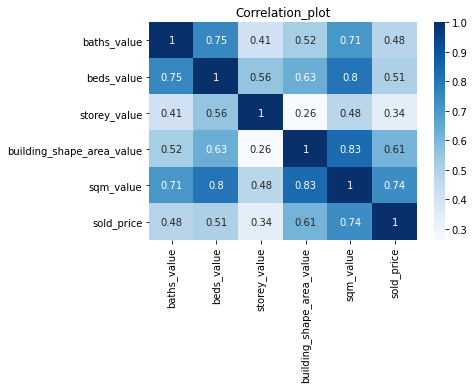

In [ ]:
# Checking Pearson's correlation with a heatmap
sns.heatmap(new_data_num.corr(), cmap = 'Blues', annot = True ).set_title('Correlation_plot')

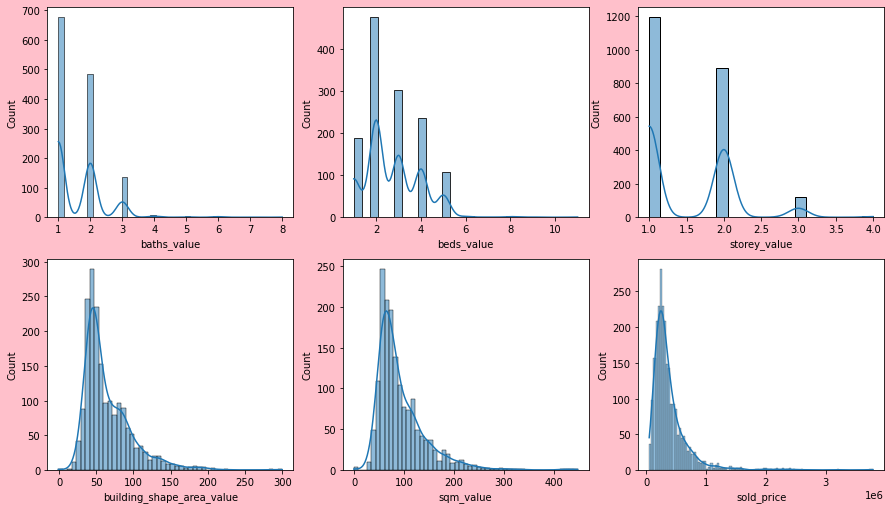

In [ ]:
plt.figure(figsize=(15,55), facecolor='pink')
plotnumber =1
for i in new_data_num:
    ax = plt.subplot(12,3,plotnumber)
    sns.histplot(new_data_num[i], kde=True)
    plt.xlabel(i)
    plotnumber+=1
plt.show() 

The above frequency distrbution and correlation clearly indicates how the values are distributed and how we could modify them on the basis of its correlated feature.

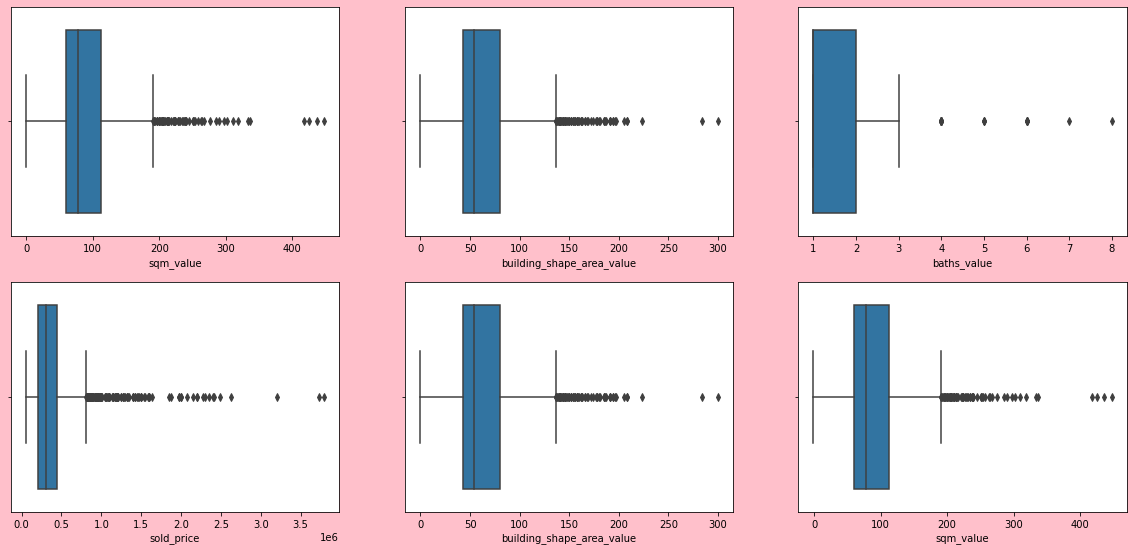

In [ ]:
# Outliers
feat = ['sqm_value','building_shape_area_value','baths_value','sold_price','building_shape_area_value','sqm_value']

plt.figure(figsize=(20,60), facecolor='pink')
plotnumber =1
for i in feat:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x = new_data_num[i], data = new_data_num)
    plt.xlabel(i)
    plotnumber+=1
plt.show()

# Imputing Storey_value and beds_value

**Storey_value and beds_value are correlated, so we can fill one column with the help of another. Logically, a building with more storeys will tend to have more number of beds. Let us check if this hypothesis is correct**

Checking not null columns in beds value and storey value, 

In [ ]:
new_data_num[(new_data_num['beds_value'].notnull()) & (new_data_num['storey_value'].notnull())]

,baths_value,beds_value,storey_value,building_shape_area_value,sqm_value,sold_price
0,1.00,1.00,1.00,nan,nan,165000
5,2.00,4.00,2.00,193.73,208.60,665000
6,1.00,3.00,2.00,43.83,69.84,370000
8,2.00,3.00,2.00,49.00,72.60,325000
10,3.00,5.00,1.00,92.27,155.75,475000
11,1.00,1.00,1.00,38.00,56.55,80000
14,1.00,2.00,1.00,nan,nan,235000
16,1.00,3.00,2.00,42.00,62.31,229000
17,2.00,4.00,2.00,88.42,122.27,660000
18,1.00,1.00,1.00,33.00,50.00,194800


Detecting NOT NULL values in both the columns above.

In [ ]:
new_data_num[new_data_num['beds_value']==1].mean()

baths_value                      1.01
beds_value                       1.00
storey_value                     1.09
building_shape_area_value       36.79
sqm_value                       48.96
sold_price                  232682.70
dtype: float64

In [ ]:
new_data_num['beds_value'].unique()

array([ 1., nan,  4.,  3.,  5.,  2.,  6., 11.,  8.,  7.,  9.])

In [ ]:
new_data_num['storey_value'].unique()

array([ 1., nan,  2.,  3.,  4.])

Corresponding NULL bed_values for UNIQUE storey_values i..e when storey=1 has 741 NULL bed_values.

In [ ]:
new_data_num[new_data_num['beds_value'].isna()]['storey_value'].value_counts()

1.00    741
2.00    207
3.00     26
4.00      5
Name: storey_value, dtype: int64

Filling NA's in Beds_value by taking the median of the beds_value across different values of storey value and vice versa

In [ ]:
storey_fillna_1 = new_data_num[new_data_num['beds_value']==1]['storey_value'].median()
storey_fillna_2 = new_data_num[new_data_num['beds_value']==2]['storey_value'].median()
storey_fillna_3 = new_data_num[new_data_num['beds_value']==3]['storey_value'].median()
storey_fillna_4 = new_data_num[new_data_num['beds_value']==4]['storey_value'].median()

beds_fillna_1 = new_data_num[new_data_num['storey_value']==1]['beds_value'].median()
beds_fillna_2 = new_data_num[new_data_num['storey_value']==2]['beds_value'].median()
beds_fillna_3 = new_data_num[new_data_num['storey_value']==3]['beds_value'].median()
beds_fillna_4 = new_data_num[new_data_num['storey_value']==4]['beds_value'].median()

new_data_num.loc[(new_data_num['beds_value']==1) & new_data_num['storey_value'].isnull(), 'storey_value'] = storey_fillna_1
new_data_num.loc[(new_data_num['beds_value']==2) & new_data_num['storey_value'].isnull(), 'storey_value'] = storey_fillna_2
new_data_num.loc[(new_data_num['beds_value']==3) & new_data_num['storey_value'].isnull(), 'storey_value'] = storey_fillna_3
new_data_num.loc[(new_data_num['beds_value']==4) & new_data_num['storey_value'].isnull(), 'storey_value'] = storey_fillna_4

new_data_num.loc[(new_data_num['storey_value']==1) & new_data_num['beds_value'].isnull(), 'beds_value'] = beds_fillna_1
new_data_num.loc[(new_data_num['storey_value']==2) & new_data_num['beds_value'].isnull(), 'beds_value'] = beds_fillna_2
new_data_num.loc[(new_data_num['storey_value']==3) & new_data_num['beds_value'].isnull(), 'beds_value'] = beds_fillna_3
new_data_num.loc[(new_data_num['storey_value']==4) & new_data_num['beds_value'].isnull(), 'beds_value'] = beds_fillna_4

In [ ]:
new_data_num.isna().sum()

baths_value                  1181
beds_value                    202
storey_value                  212
building_shape_area_value     649
sqm_value                     887
sold_price                      0
dtype: int64

Even after reducing NA's from 1987 to 1181 of beds value still we could find loads of them.So applying KNN Imputer for numerical data

# **Imputing missing value with Knn imputation**

The k nearest neighbors algorithm can be used for imputing missing data by finding the k closest neighbors to the observation with missing data and then imputing them based on the the non-missing values in the neighbors. There are several possible approaches to this. You can use 1NN schema, where you find the most similar neighbor and then use its value as a missing data replacement. Alternatively you can use kNN, with k neighbors and take mean of the neighbors, or weighted mean, where the distances to neighbors are used as weights, so the closer neighbor is, the more weight it has when taking the mean. Using weighted mean seems to be used most commonly.

In [ ]:

imputer = KNNImputer(n_neighbors=5)
new_data_num[:] = imputer.fit_transform(new_data_num)

In [ ]:
new_data_num.isna().sum()

baths_value                  0
beds_value                   0
storey_value                 0
building_shape_area_value    0
sqm_value                    0
sold_price                   0
dtype: int64

In [ ]:
# Converting to int
new_data_num['storey_value'] = pd.to_numeric(new_data_num.loc[:, ('storey_value')]).astype(int)
new_data_num['beds_value'] = pd.to_numeric(new_data_num.loc[:, ('beds_value')]).astype(int)
new_data_num['baths_value'] = pd.to_numeric(new_data_num.loc[:, ('baths_value')]).astype(int)

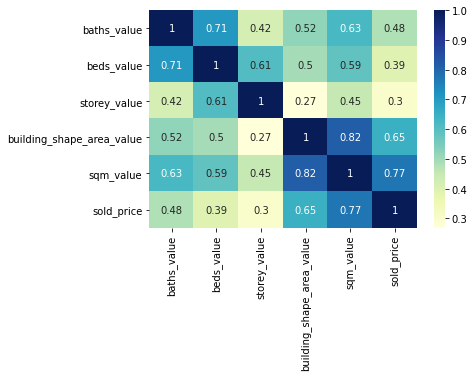

In [ ]:
sns.heatmap(new_data_num.corr(), cmap = 'YlGnBu', annot = True )

Correlaton matrix also shows high correlation between sqm_value and selling price as it is logical in some ways.So let us see how the correlation varies

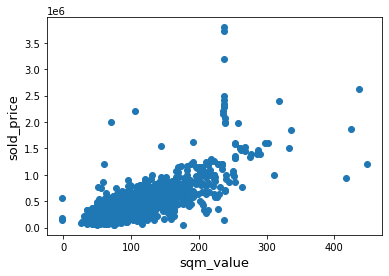

In [ ]:
# Since sold_price and sqm value have very high correlation, let's plot the relationship
# There are a few outliers in the data
fig, ax = plt.subplots()
ax.scatter(x = new_data_num['sqm_value'], y = new_data_num['sold_price'])
plt.ylabel('sold_price', fontsize=13)
plt.xlabel('sqm_value', fontsize=13)
plt.show()

How is Sqm_value correlated to building shape_area and how mcuh let's see!

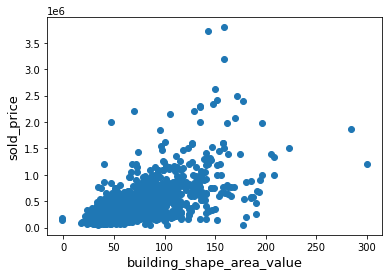

In [ ]:
#Similarly visualising for building_shape_area_value
fig, ax = plt.subplots()
ax.scatter(x = new_data_num['building_shape_area_value'], y = new_data_num['sold_price'])
plt.ylabel('sold_price', fontsize=13)
plt.xlabel('building_shape_area_value', fontsize=13)
plt.show()

We can conclude that building_shape_area_value,sqm_value & sod_price are inter-linked are highly correlated to one another as they form clusters of certain type which we could further analyse if demanded.

We can one hot encode the categorical features. It performs better than LablelEncoder when the features are not ordinal and as the no of categorical var are less.

In [ ]:
new_data_cat.head()

,post_county_name,eir_value,building_property_subtype_code,new_home_ind,soldyear_disc,Quarter,yoc_disc
0,dublin,low_eir_counties,multi-family,0,"(2014.0, 2016.0]",Q4,"(1990.0, 1997.0]"
1,dublin,med_eir_counties,mid-terrace,1,"(2016.0, 2018.0]",Q4,"(1997.0, 2019.0]"
2,dublin,high_eir_counties,mid-terrace,0,"(2014.0, 2016.0]",Q4,"(1955.0, 1990.0]"
3,dublin,high_eir_counties,semidetached,0,"(2016.0, 2018.0]",Q4,"(1955.0, 1990.0]"
4,dublin,low_eir_counties,multi-family,0,"(2016.0, 2018.0]",Q4,"(1955.0, 1990.0]"


Converting categorical variables to numericals helps in keeping training time low and performance high.

In [ ]:
new_data_cat_encoded = pd.get_dummies(new_data_cat)

Concatenating categorical and numerical var

In [ ]:
new_data = pd.concat([new_data_cat_encoded,new_data_num],axis=1)


I created two features age of th property and total area but it was not contributing much for sold price prediction.

**Baseline Benchmarking of different models on raw data was done using Pycaret. Several insights on data was gathered on Model Performance using Pycaret library. Various models been compared before choosing XGB and RandomForest regressor**

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using kfold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, R2, RMSLE and MAPE accross the folds (10 by default) of all the available models in the model library

![image.png]()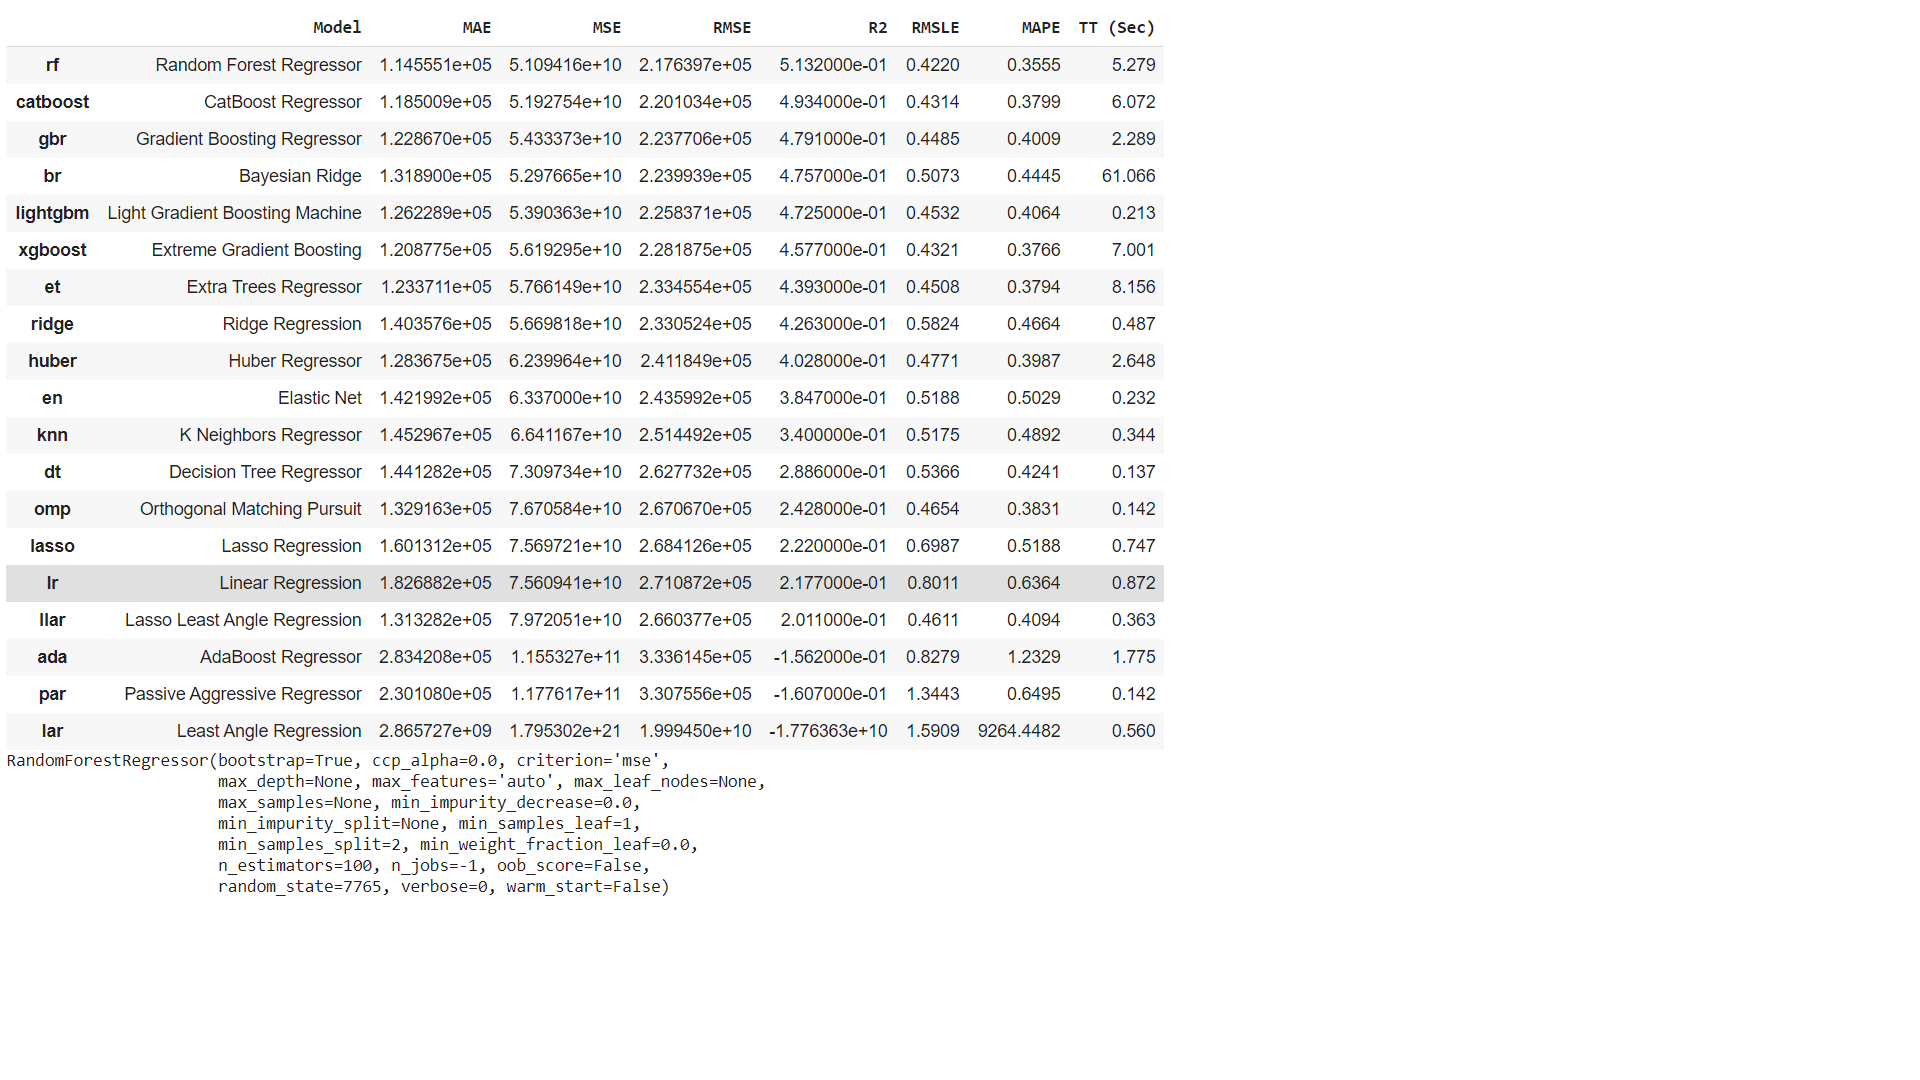

Initial benchmarking was done on regularized linear regressors like ridge regressors. Linear classifiers are prone to outliers, but regularized regressors such as ridge regression penalizes the squared size of coefficients. Ridge offers feature shrinkage. Ridge regressor is not prone to outliers, hence it works well on our data

# Regression Modeling - XGBoost , RandomForest Regressors

**Choosing correct type of Regression analysis**

OLS(Ordinary Least square) and linear least square are sensitive to both outliers and multicollinearity.

Is multicoliinearity a problem in regression?
Multicollinearity means correlation between independent variables.Stronger the correlation more difficult it is for the model to estimate relationship between independent variables and it does try to weak statistical power of the model.

Slightly different models can lead to very different conclusions as correlation changes dramatically.This makes us not to trust p-values(tells about which features to keep in regression) to select independent variable.But treating multicollinearity depends on the primary goal of regression problem and which is not affected by multicollinearity.

RF is an ensembling algorithm which consists of growing several decision trees in parallel and combining their output to make analysis.Here,each DT is a 'weak learner' is built upon a different random subset of training set,thereby learning diferent patterns.Combining predictions of group of trees often yields better results than indicidual DT.

XGBoost on the other hand is used to for faster parallel computation

Expecting performance on a dataset depends on the models,so using a test harness of 5-fold cross validations,naive model like linear regression can achieve MAE of 6.5 while that of a top-performing model like XGBoost or RandomForest can achieve a MAE on the same test as 1.9

Linear regressors are more prone to outliers and multicollinearity, i applied various linear algorithms but results were not satisfactory. I got higher rmse for linear regressors. Non linear regressor on the other hand are less prone to outliers, random forest worked for me the best as its an ensemble of multiple weak learners(decision tree). Decision tree is prone to outliers but random forest which trains multiple weak learners cancel out the affect of individual weak learner. Further i tried boosting algorithm as boosting algorithm learns from the wrong predictions. It builds its model considering wrong predictions as its training set hence it performed better.

Decision tree and general tree based methods are a type of supervised learning algorithm (having a pre-defined target variable) that is mostly used in classification problems. As noted above they are used in regression problems if and only if the target variable is inside the range of values that they have seen in the train dataset.

Small variation in data can completely change the decision tree, hence in those scenario we need to use boosting algorithm which can work on errorneous predictions and correct results. However, as random forest create multiple tree and use multiple trees to make predictions and further average the predictions, its slow in production environment and also when the data size is too much. It can be a drawback

In [ ]:
## Defining our scorer error functions to minimise
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true))
score = make_scorer(median_absolute_percentage_error)

def median_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median((y_true - y_pred) / y_true) 

scoring = {'mdape': make_scorer(median_absolute_percentage_error),
           'mape': make_scorer(median_percentage_error)}

Copying DF in a new DF to separatae target var (sold_price) like what factors are affecting the selling price of the properties.

In [ ]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

nd = new_data.copy()
y = nd.pop('sold_price')
X = nd
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]


### Cross validation using XGB



GridSearchCV is used to pick the best hyper parameter combination in the provided parameter grid.

RandomizedSearch produces the following optimal combination of hyperparameters unlike GridSearchCV which uses static coombination.

In [ ]:
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.01, .03, 0.05,], #so called `eta` value
#               'max_depth': [3, 5, 7],
#               'min_child_weight': [2, 4, 6],
#               'silent': [1, 3, 5],
#               'subsample': [0.3, 0.5],
#               'colsample_bytree': [0.3, 0.5],
#               'n_estimators': [100, 200, 500]}
# xgb1 = xgb.XGBRegressor()
# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 5,
#                         n_jobs = 5,
#                         scoring =scoring
#                         verbose=True)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.03,
                max_depth = 5, alpha = 10, n_estimators = 500, min_child_weight = 2, nthread = 4, silent =1, subsample=0.5)

scores = cross_validate(xg_reg, X, y, cv=5, scoring=scoring,
                    return_train_score=True)

In [ ]:
print("The MAPE for XGB using 5 fold CV is : ", round(np.mean(scores['test_mape'])*100,2),"%")
print("The MdAPE for XGB using 5 fold CV is : ", round(np.mean(scores['test_mdape'])*100,2),"%")

The MAPE for XGB using 5 fold CV is :  -1.88 %
The MdAPE for XGB using 5 fold CV is :  16.72 %


### Cross validation using Random Forest

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

"""rf = RandomForestRegressor()
random_grid = {'bootstrap': [True, False],
  'max_depth': [10, 20, 30, 40, 50],
  'max_features': ['auto', 'sqrt'],
  'min_samples_leaf': [1, 2, 4, 8],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [200, 400, 800, 1000]}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, scoring='neg_median_absolute_error', n_jobs = 3 )
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, scoring='neg_median_absolute_error', n_jobs = 3 )"""

"rf = RandomForestRegressor()\nrandom_grid = {'bootstrap': [True, False],\n  'max_depth': [10, 20, 30, 40, 50],\n  'max_features': ['auto', 'sqrt'],\n  'min_samples_leaf': [1, 2, 4, 8],\n  'min_samples_split': [2, 5, 10],\n  'n_estimators': [200, 400, 800, 1000]}\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, scoring='neg_median_absolute_error', n_jobs = 3 )\nrf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, scoring='neg_median_absolute_error', n_jobs = 3 )"

In [ ]:
rf = RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=10, n_estimators=200)
scores_rf = cross_validate(rf, X, y, cv=5, scoring=scoring,
                    return_train_score=True)

In [ ]:
print("The MAPE for Random Forest using 5 fold CV is : ", round(np.mean(scores_rf['test_mape'])*100,2),"%")
print("The MdAPE for Random Forest using 5 fold CV is : ", round(np.mean(scores_rf['test_mdape'])*100,2),"%")

The MAPE for Random Forest using 5 fold CV is :  -5.22 %
The MdAPE for Random Forest using 5 fold CV is :  18.56 %


## Using Holdout testing for both XGB and RF

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.03,
#                 max_depth = 5, alpha = 10, n_estimators = 500, min_child_weight = 2, nthread = 4, silent =1, subsample=0.5)


xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=None, n_estimators=500,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.5, verbosity=1)

In [ ]:
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]
y_pred = xg_reg.predict(X_test)

Below plot shows feature importance and even though we have encoded variables,this isn't affecting our feature importance across multiple features

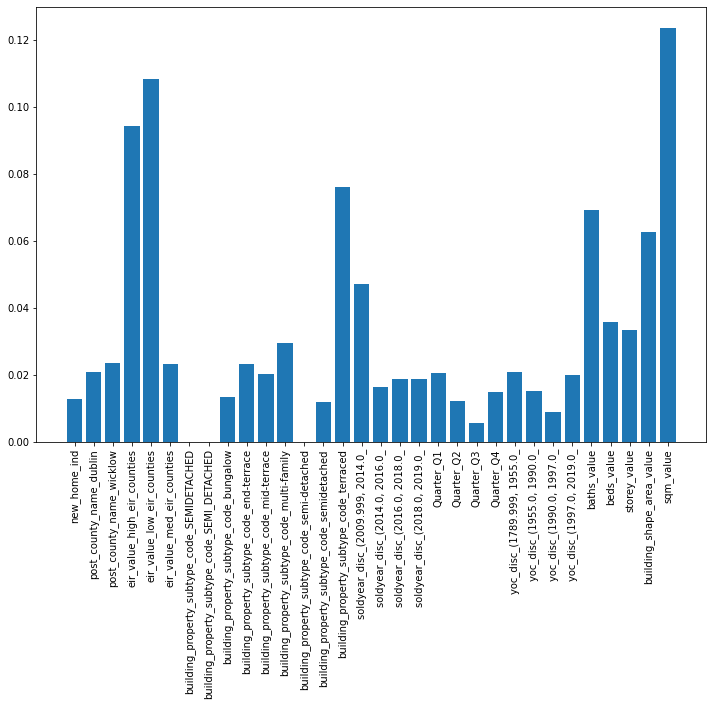

In [ ]:
xg_reg.feature_importances_
plt.figure(figsize = (12,8))
plt.bar(X_train.columns,xg_reg.feature_importances_)
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=10)
plt.show()



In [ ]:
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)
metrics_df = pd.concat([y_test_df,y_pred_df],axis=1)
# Calculating Percentage error and abs percentage error
metrics_df['PE'] = (metrics_df[0]-metrics_df['sold_price'])/metrics_df['sold_price']
metrics_df['APE'] = np.abs(metrics_df['PE']) 

In [ ]:
print("The MAPE for XGB using 33% Holdout testing is : ", round(np.median(metrics_df['PE'])*100,2),"%")
print("The MdAPE for XGB using 33% Holdout testing is : ", round(np.median(metrics_df['APE'])*100,2),"%")

The MAPE for XGB using 33% Holdout testing is :  1.7 %
The MdAPE for XGB using 33% Holdout testing is :  17.79 %


In [ ]:
print("PPE20 XGB Holdout :", (np.round(metrics_df[metrics_df['APE']<=0.20].shape[0]/(metrics_df.shape[0]),2)))
print("PPE10 XGB Holdout :", (np.round(metrics_df[metrics_df['APE']<=0.10].shape[0]/(metrics_df.shape[0]),2)))

PPE20 XGB Holdout : 0.55
PPE10 XGB Holdout : 0.29


### TASK 3 - FORECAST STANDARD DEVIATION

We have to calculate the 68th percentile of the absolute error term in order to get the confidence with which we can state the Forecast standard deviation.FSD score is the likeliness that valuation is accurate for AVM

In [ ]:
metrics_df['FSD'] = np.round(metrics_df['APE'] * 100)
print( "With 68% confidence the FSD is : ", np.percentile(metrics_df['FSD'], 68) )


With 68% confidence the FSD is :  27.0


FSD is 27 with 68% confidence is acceptable and our XGB model produces it

### Let's see how RandomForest performs

##### Random Forest

In [ ]:
rf.fit(X_train,y_train)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]
y_pred = rf.predict(X_test)


In [ ]:
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)
metrics_df = pd.concat([y_test_df,y_pred_df],axis=1)
# Calculating Percentage error and abs percentage error
metrics_df['PE'] = (metrics_df[0]-metrics_df['sold_price'])/metrics_df['sold_price']
metrics_df['APE'] = np.abs(metrics_df['PE']) 

In [ ]:
print("The MAPE for RF using 33% Holdout testing is : ", round(np.median(metrics_df['PE'])*100,2),"%")
print("The MdAPE for RF using 33% Holdout testing is : ", round(np.median(metrics_df['APE'])*100,2),"%")
print("PPE20 RF Holdout :", (np.round(metrics_df[metrics_df['APE']<=0.20].shape[0]/(metrics_df.shape[0]),2)))
print("PPE10 RF Holdout :", (np.round(metrics_df[metrics_df['APE']<=0.10].shape[0]/(metrics_df.shape[0]),2)))

The MAPE for RF using 33% Holdout testing is :  5.52 %
The MdAPE for RF using 33% Holdout testing is :  18.72 %
PPE20 RF Holdout : 0.53
PPE10 RF Holdout : 0.27


## Future Scope

1. RandomForest and XGB can be stacked together and used for prediction for better results and as well can invest more time and train other ML algorithms like Support Vector Machine for regression ,a KNN or a neural network.

2. Check for Feature Engineering  after Gridsearch and weight the columns with high importance.
3. Scraping more data for further analysis.

4. Neural networks can be used, Tabnet has proven to perform better in regression problems specially for house price prediction. 

TabNet is a Deep Neural Network for tabular data and was designed to learn in a similar way than decision tree based models, in order to have their benefits : interpretability and sparse feature selection. TabNet uses sequential attention to choose which features to reason from at each decision step, enabling interpretability and better learning (as the learning capacity is used for the most salient/important features). The feature selection is instancewise, so it can be different for each input.

It can still be a good model to add in an ensembling because it is quite fast to train and can add different capabilities, so make the ensembling more exhaustive

5. Features like EIRcode can be analysed more to see why properties in these areas are having low% of selling price.
6. Introducing newer features into the data that would bring in further exploration like how properties near stations or parks or beaches and distance of site from station or even university are sold or ating of the view from the site like mountains or river and how are the prices varying while taking them into consideration.